https://finance.yahoo.com/commodities/

https://gsnchez.com/blog/article/Optimizacion-algoritmica-de-carteras-con-markowitz

Importamos las librerias necesarias.

In [1]:
import pandas as pd
import numpy as np
from pandas_datareader import data as wb
import matplotlib.pyplot as plt
from time import time
from sklearn.gaussian_process.kernels import RBF
from sklearn.gaussian_process import GaussianProcessRegressor

Descargamos el dataset a estudiar.

In [2]:
natural_gas = wb.DataReader('NG=F', data_source='yahoo', start='1900-1-1')

In [3]:
natural_gas.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2000-08-30,4.815,4.63,4.65,4.805,34954.0,4.805
2000-08-31,4.870,4.74,4.82,4.780,25787.0,4.780
2000-09-01,4.860,4.75,4.75,4.835,113.0,4.835
2000-09-05,4.975,4.84,4.85,4.960,26096.0,4.960
2000-09-06,5.110,4.96,4.99,5.065,32764.0,5.065


Transformamos el dataset a series de precios (Adj Close) anuales.

In [4]:
starts, ends = [], []
for i in range(1,22):
    starts.append('20{:02d}-01-01'.format(i))
    ends.append('20{:02d}-12-31'.format(i))

In [5]:
natural_gas_years = pd.DataFrame()
for start, end in zip(starts, ends):
    s = [None] * 253
    v = natural_gas['Adj Close'][start:end].values
    v = (v - v[0]) / np.std(v)
    s[:len(v)] = v
    natural_gas_years[end[:4]] = s

In [6]:
natural_gas_years.head()

,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,-0.087652,-0.263747,0.116941,0.304226,0.039893,-0.407873,-0.202118,-0.081959,0.137199,-0.437133,...,0.205340,-0.108265,-0.034233,-0.441128,-0.016922,-0.341345,-0.098705,-0.047391,0.017916,0.117108
2,0.387127,-0.254375,-0.397347,0.060845,0.015316,-1.071496,-0.203604,-0.004191,0.016300,0.221221,...,-0.025917,0.167036,-0.030205,-0.236970,-0.125978,-0.307211,-0.361917,0.313512,0.029114,0.130657
3,0.539300,-0.258391,-0.155921,0.318543,0.092253,-0.945046,-0.170908,0.013505,-0.134483,-0.138041,...,0.137558,0.102078,-0.044301,-0.481231,0.090252,-0.238941,-0.536706,-0.051037,0.089580,0.143239
4,0.813211,-0.246342,-0.113169,0.548801,0.075156,-1.175127,0.117407,0.054484,-0.527064,-0.238918,...,0.035884,-0.046399,-0.211434,-0.277072,0.259476,-1.274357,-0.454452,0.032810,0.042551,0.115172


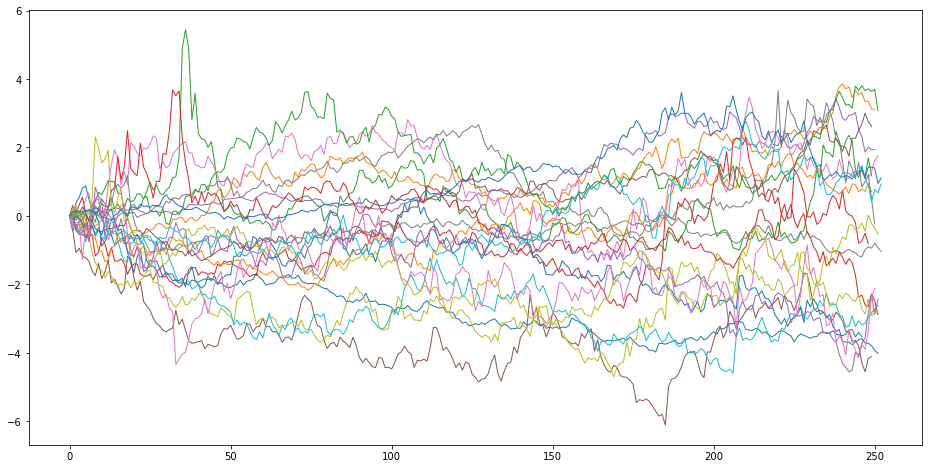

In [7]:
natural_gas_plot = natural_gas_years.plot(figsize=(16,8), legend=False, linewidth=1)

Obtenemos las matrices X e y. La matriz X tiene como columnas la variable año actual y la variable dia actual. La matriz y tiene los precios correspondientes a cada fila de X.

In [8]:
def quarter(day):
    if day <= 61:
        return 0
    elif day > 61 and day <= 61 * 2:
        return 1
    elif day > 61 * 2 and day <= 61 * 3:
        return 2
    else:
        return 3

In [9]:
days = natural_gas_years.index.values
years = [int(year) for year in natural_gas_years.columns.values]

X, y, i = pd.DataFrame(columns=['year', 'quarter', 'day']), np.array([None] * len(years) * len(days)), 0
for year in years:
    for day in days:
        X.loc[i, 'year'], X.loc[i, 'quarter'], X.loc[i, 'day'] = year, quarter(day), day
        y[i] = natural_gas_years[str(year)].values[day]
        i += 1

X = X.loc[~np.isnan(list(y)),:].reset_index(drop=True)
y = y[~np.isnan(list(y))]

Iteramos entrenando un GP con kernel rbf sobre los años anteriores a n y el primer trimeste de n, y predecimos el resto del año n para n entre 2016 y 2021.

Predicting year 2016 with data from 2001 to 2015
Elapsed time: 66.675s
Log-marginal-likelihood: -4166.307
Predicting year 2017 with data from 2001 to 2016
Elapsed time: 117.354s
Log-marginal-likelihood: -4440.286
Predicting year 2018 with data from 2001 to 2017
Elapsed time: 92.274s
Log-marginal-likelihood: -4815.004
Predicting year 2019 with data from 2001 to 2018


/home/marcoscobocarrillo/miniconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Elapsed time: 171.844s
Log-marginal-likelihood: -5208.373
Predicting year 2020 with data from 2001 to 2019
Elapsed time: 105.570s
Log-marginal-likelihood: -5593.480
Predicting year 2021 with data from 2001 to 2020
Elapsed time: 127.882s
Log-marginal-likelihood: -5977.386


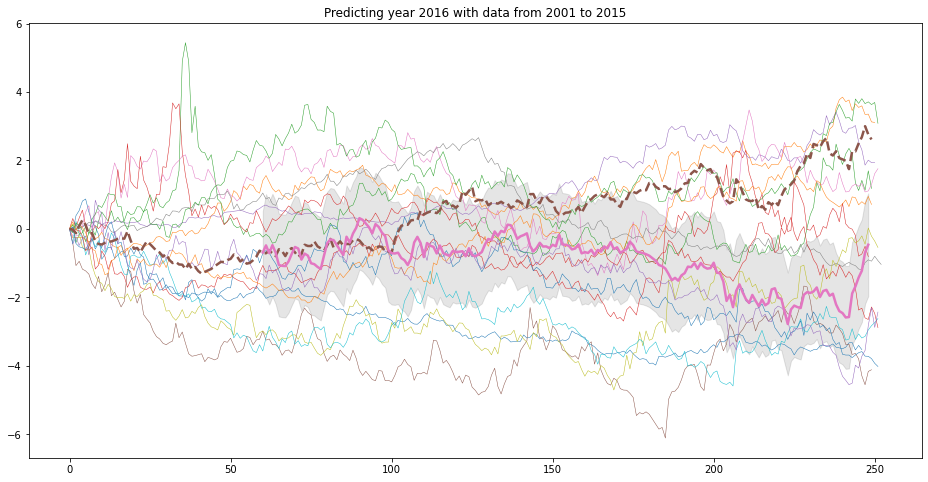

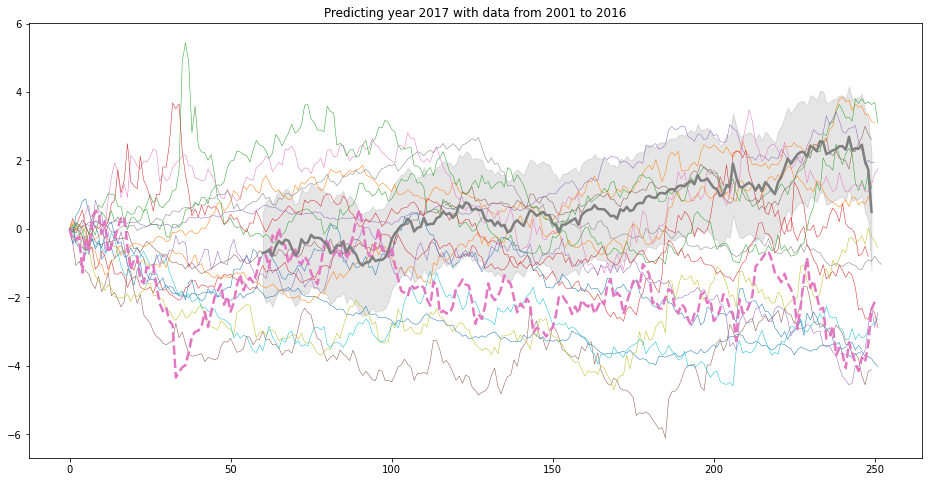

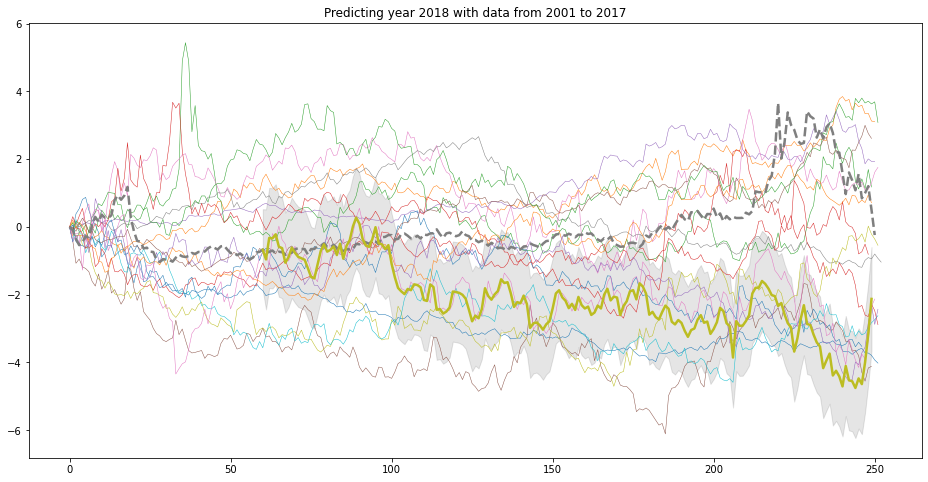

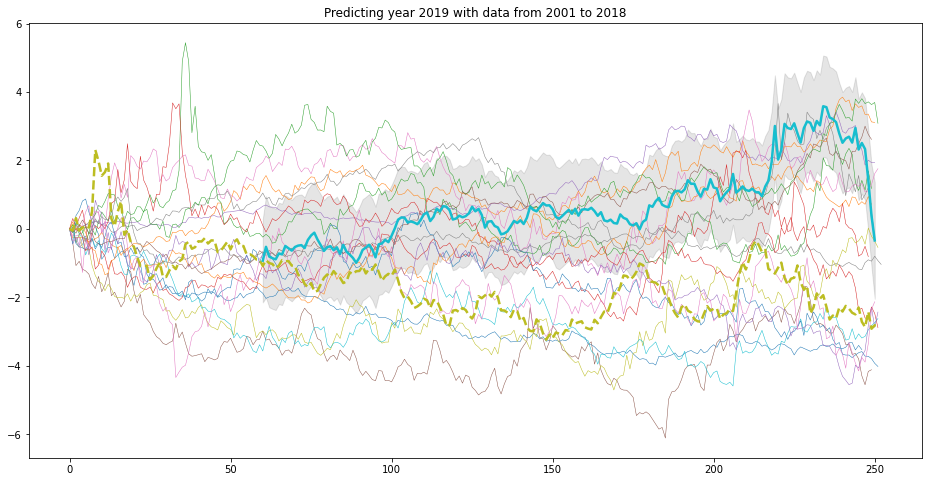

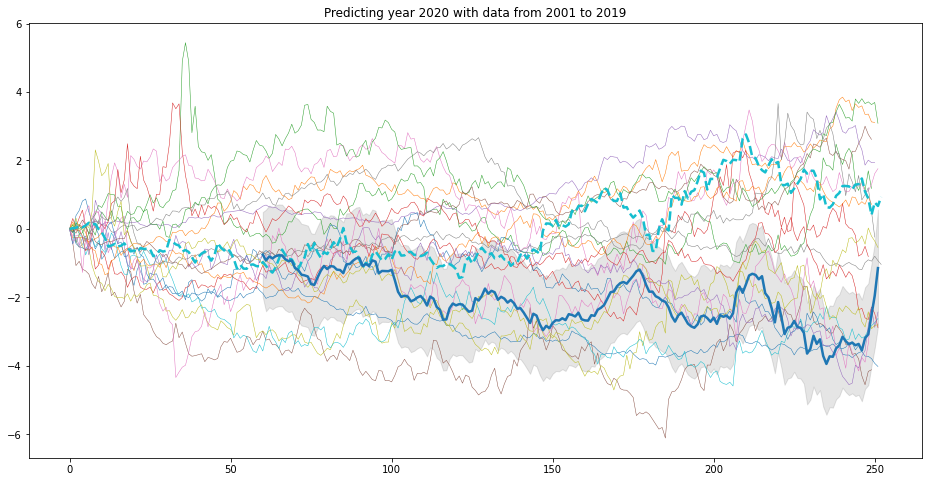

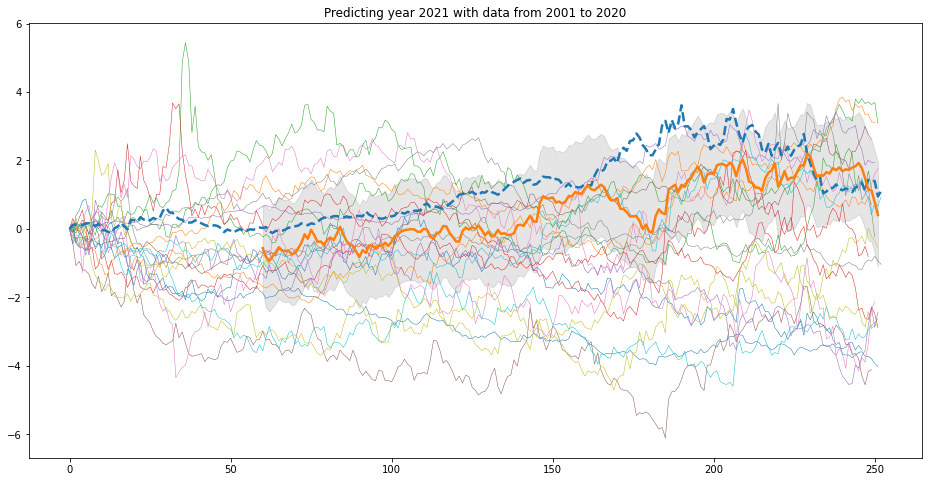

In [10]:
years_pred, days_pred = range(2016, 2022), 60
for year_pred in years_pred:
    
    title = 'Predicting year {} with data from 2001 to {}'.format(year_pred, year_pred - 1)
    print(title)
    
    X_train = X.loc[(X['year'] < year_pred) | ((X['year'] == year_pred) & (X['day'] <= days_pred))]
    y_train = y[X_train.index]
    
    X_test = X.loc[(X['year'] == year_pred) & (X['day'] > days_pred)]
    y_test = y[X_test.index]
    
    kernel = RBF()
    gp = GaussianProcessRegressor(kernel=kernel,
                                  normalize_y=True,
                                  n_restarts_optimizer=1,
                                  random_state=2)
    t0 = time()
    gp.fit(X_train, y_train)
    print("Elapsed time: %0.3fs" % (time() - t0))
    print("Log-marginal-likelihood: %.3f" % gp.log_marginal_likelihood(gp.kernel_.theta))
    
    y_pred, y_std = gp.predict(X_test, return_std=True)
    
    hco = natural_gas_years.loc[:,:'{}-01-01'.format(year_pred - 1)].plot(figsize=(16,8), legend=False, linewidth=.5, title=title)
    p = hco.plot(natural_gas_years[str(year_pred)], linewidth=2.5, linestyle='--')
    y_plot, y_plot[days_pred:] = [None] * (len(y_pred) + days_pred), y_pred
    p = hco.plot(y_plot, linewidth=2.5)
    p = hco.fill_between(range(days_pred, len(y_pred) + days_pred), y_pred - y_std, y_pred + y_std, alpha=0.1, color='k')
    f = hco.get_figure()
    f.savefig('Figures/{}.png'.format(year_pred))